# Query Log Analysis

## Functionalities
- Plot number of database queries per second.
- Plot instantaneous latency of database queries.
- Plot latency distribution of database queries.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    *_service*.tar.gz
  ...
  [node-n]/
    *_service*.tar.gz
```

## Notebook Configuration

In [9]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2022-04-14-05-26-13"

########## LATENCY
# Bin size
LATENCY_BIN_IN_MS = 100

## Notebook Setup

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from utils.utils import *

experiment_dirpath = os.path.join(os.path.abspath(""), "..", "data", EXPERIMENT_DIRNAME)

## Log Parsing & Processing

In [11]:
# Build data frame
query = pd.concat([df[2] for df in get_query_df(experiment_dirpath)])

In [12]:
# Extract experiment information
start_time = get_experiment_start_time(experiment_dirpath)
max_latency_in_s = int(query["latency"].max()) + 1.0
dbnames = sorted(query["dbname"].unique())
types = sorted(query["type"].unique())

In [13]:
# (Re) Build columns
query["timestamp"] = query.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
query["latency"] = query["latency"].multiply(1000)
query["window_1000"] = query["timestamp"].round(0).multiply(1000)
query["window_10"] = query["timestamp"].round(2).multiply(1000)

In [14]:
# (Re) Create index
query.set_index("timestamp", inplace=True)
query.sort_index(inplace=True)

## Number of Queries per Second

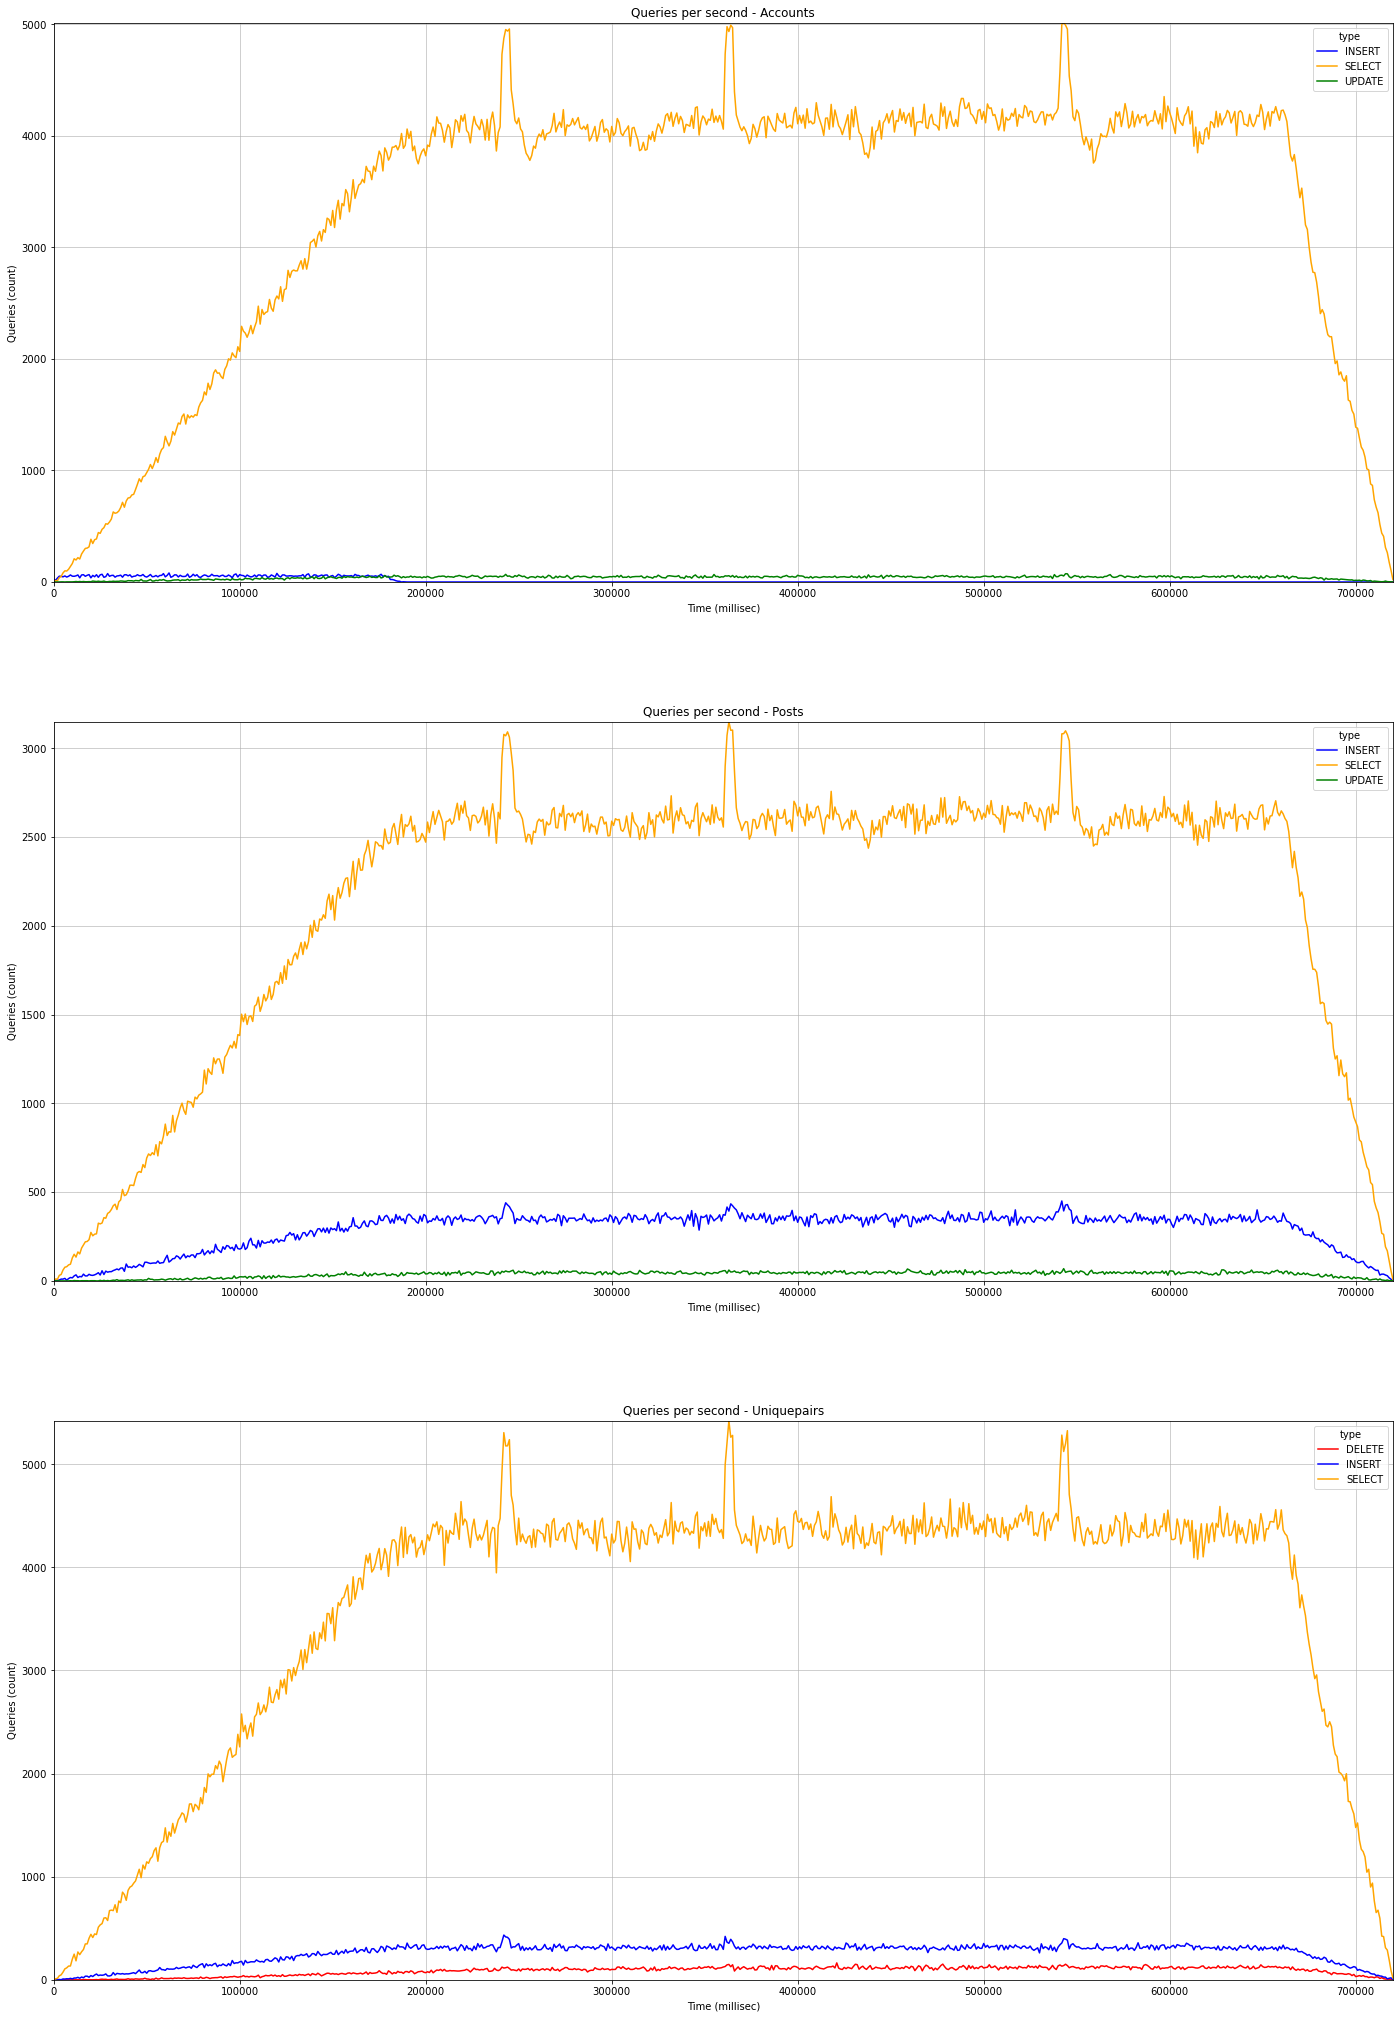

In [15]:
fig = plt.figure(figsize=(24, len(dbnames) * 12))
for (i, dbname) in enumerate(dbnames):
    # Data frame
    df = query[(query["dbname"] == dbname)].groupby(["window_1000", "type"])["window_1000"].count().unstack().fillna(0)
    df = df.reindex(range(0, int(df.index.max()) + 1, 1000), fill_value=0)
    # Plot
    ax = fig.add_subplot(len(dbnames), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((int(df.index.min()), int(df.index.max())))
    ax.set_ylim((0, int(df.values.max())))
    df.plot(ax=ax, kind="line", title="Queries per second - %s" % dbname, xlabel="Time (millisec)", ylabel="Queries (count)", color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"}, legend=True, grid=True)
    plt.subplots_adjust(hspace=0.25)

In [16]:
########## ZOOM IN
# Minimum time (in sec)
MIN_TIME = None
# Maximum time (in sec)
MAX_TIME = None

if MIN_TIME and MAX_TIME:
    fig = plt.figure(figsize=(24, len(dbnames) * 12))
    for (i, dbname) in enumerate(dbnames):
        # Data frame
        df = query[(query["dbname"] == dbname) & (query.index >= MIN_TIME) & (query.index <= MAX_TIME)].groupby(["window_10", "type"])["window_10"].count().unstack().fillna(0)
        df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1, 10), fill_value=0)
        # Plot
        ax = fig.add_subplot(len(dbnames), 1, i + 1)
        ax.grid(alpha=0.75)
        ax.set_xlim((int(df.index.min()), int(df.index.max())))
        ax.set_ylim((0, int(df.values.max())))
        df.plot(ax=ax, kind="line", title="Queries per second - %s" % dbname, xlabel="Time (millisec)", ylabel="Queries (count)", color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"}, legend=True, grid=True)
        plt.subplots_adjust(hspace=0.25)

## Instantaneous Latency of Queries

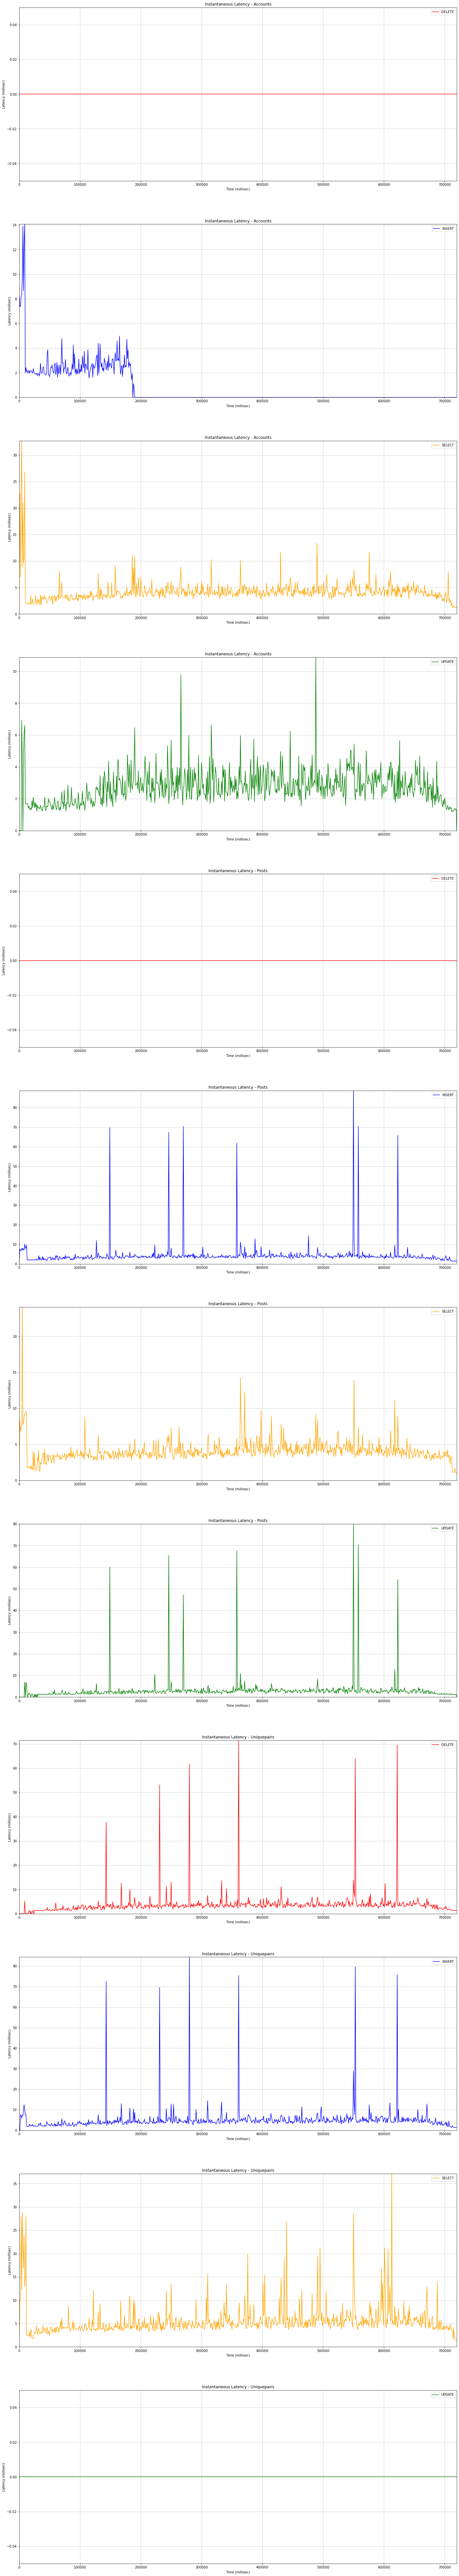

In [17]:
fig = plt.figure(figsize=(24, len(dbnames) * len(types) * 12))
for (i, dbname) in enumerate(dbnames):
    for (j, type) in enumerate(types):
        # Data frame
        df = query[(query["dbname"] == dbname) & (query["type"] == type)].groupby(["window_1000"])["latency"].max().reindex(range(0, int(query["window_1000"].max()) + 1, 1000), fill_value=0)
        # Plot
        ax = fig.add_subplot(len(dbnames) * len(types), 1, i * len(types) + j + 1)
        ax.grid(alpha=0.75)
        ax.set_xlim((0, int(df.index.max())))
        ax.set_ylim((0, df.values.max()))
        df.plot(ax=ax, kind="line", title="Instantaneous Latency - %s" % dbname, xlabel="Time (millisec)", ylabel="Latency (millisec)", label=type, color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"}, legend=True, grid=True)
        plt.subplots_adjust(hspace=0.25)

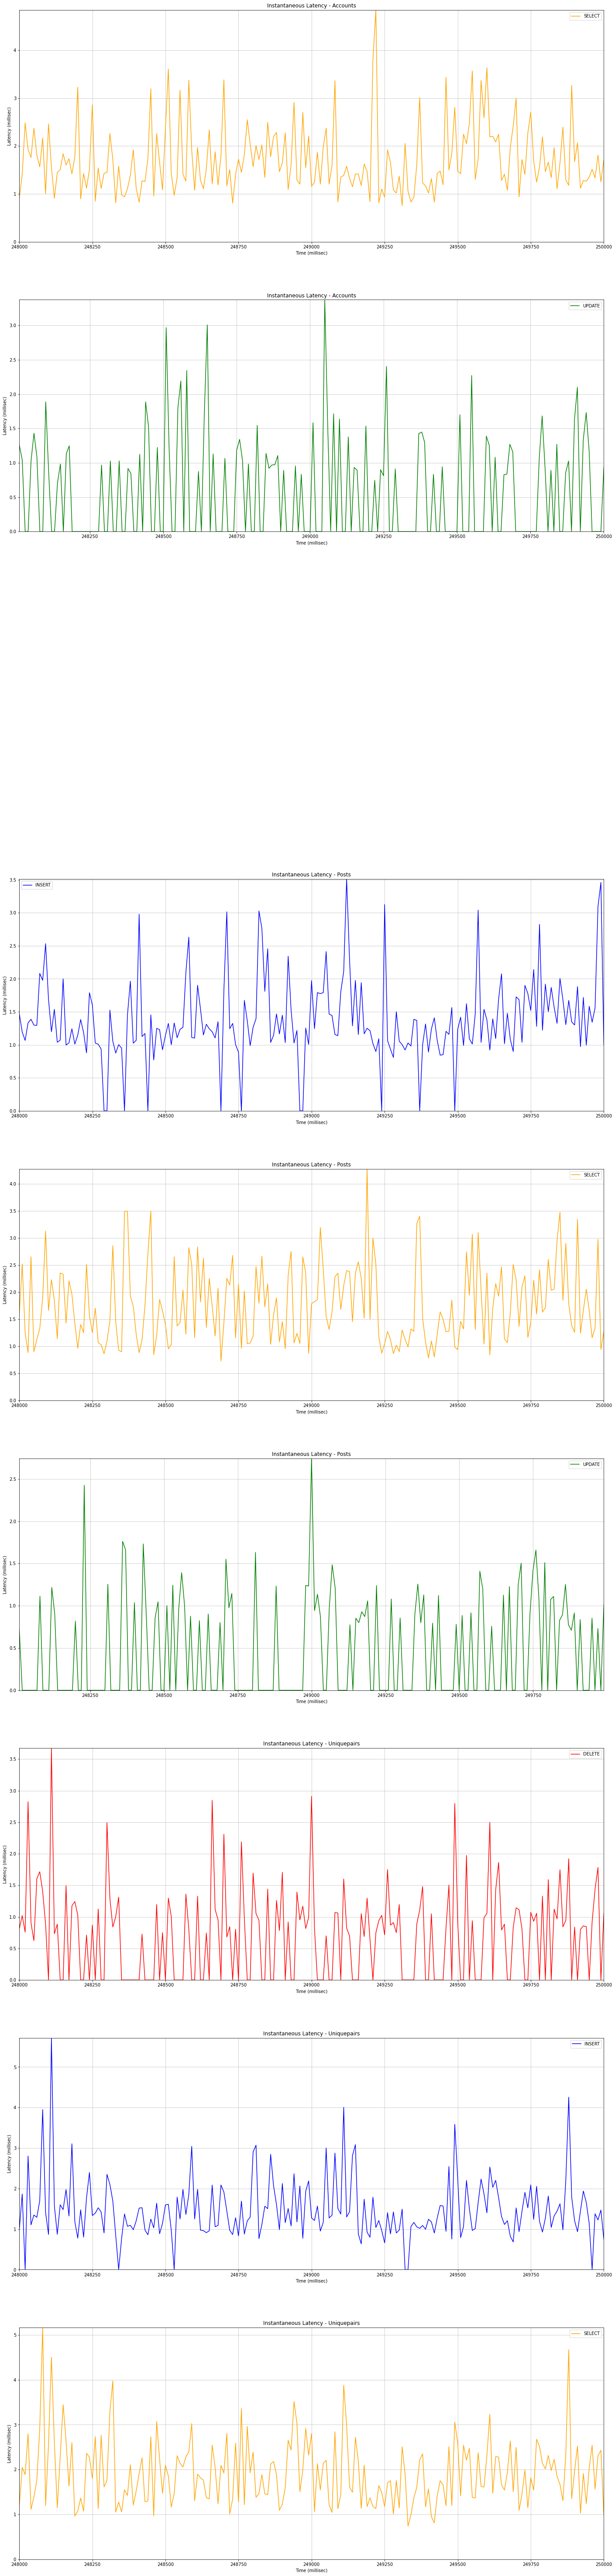

In [21]:
########## ZOOM IN
# Minimum time (in sec)
MIN_TIME = 248
# Maximum time (in sec)
MAX_TIME = 250

if MIN_TIME and MAX_TIME:
    fig = plt.figure(figsize=(24, len(dbnames) * len(types) * 12))
    for (i, dbname) in enumerate(dbnames):
        for (j, type) in enumerate(types):
            # Data frame
            df = query[(query["dbname"] == dbname) & (query["type"] == type) & (query.index >= MIN_TIME) & (query.index <= MAX_TIME)].groupby(["window_10"])["latency"].max()
            if df.empty:
                continue
            df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1, 10), fill_value=0)
            # Plot
            ax = fig.add_subplot(len(dbnames) * len(types), 1, i * len(types) + j + 1)
            ax.grid(alpha=0.75)
            ax.set_xlim((int(df.index.min()), int(df.index.max())))
            ax.set_ylim((0, df.values.max()))
            df.plot(ax=ax, kind="line", title="Instantaneous Latency - %s" % dbname, xlabel="Time (millisec)", ylabel="Latency (millisec)", label=type, color={"SELECT": "orange", "INSERT": "blue", "DELETE": "red", "UPDATE": "green"}, legend=True, grid=True)
            plt.subplots_adjust(hspace=0.25)

## Latency Distribution of Queries

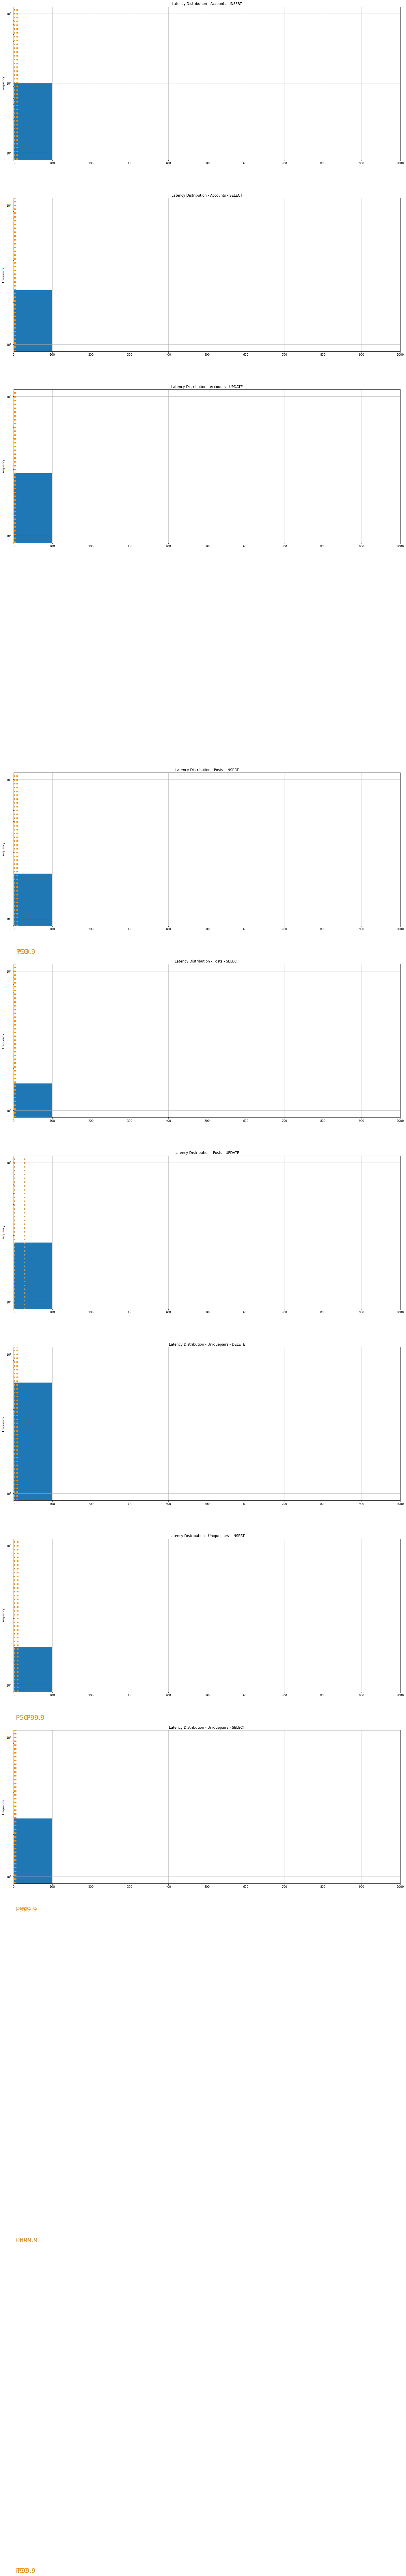

In [19]:
fig = plt.figure(figsize=(24, len(dbnames) * len(types) * 12))
for (i, dbname) in enumerate(dbnames):
    for (j, type) in enumerate(types):
        # Data frame
        df = query[(query["dbname"] == dbname) & (query["type"] == type)]
        if df.empty:
            continue
        df["latency_bin"] = df.apply(lambda r: int(r["latency"] // LATENCY_BIN_IN_MS), axis=1)
        p999 = df["latency"].quantile(0.999)
        p50 = df["latency"].quantile(0.50)
        # Plot
        ax = fig.add_subplot(len(dbnames) * len(types), 1, i * len(types) + j + 1)
        ax.set_yscale("log")
        ax.grid(alpha=0.75)
        ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * max_latency_in_s))
        ax.set_xticks(range(int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1))
        ax.set_xticklabels(range(0, (int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1) * LATENCY_BIN_IN_MS, LATENCY_BIN_IN_MS))
        ax.axvline(x=p50 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
        ax.text(x=p50 / LATENCY_BIN_IN_MS, y=10, s=" P50", fontsize=22, color="darkorange")
        ax.axvline(x=p999 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
        ax.text(x=p999 / LATENCY_BIN_IN_MS, y=10, s=" P99.9", fontsize=22, color="darkorange")
        df["latency_bin"].plot(ax=ax, kind="hist", title="Latency Distribution - %s - %s" % (dbname, type), xlabel="Latency (milliseconds)", ylabel="Queries (count)", bins=range((1000 // LATENCY_BIN_IN_MS) * int(max_latency_in_s)), grid=True)
        plt.subplots_adjust(hspace=0.25)

## Statistics

In [20]:
for (i, dbname) in enumerate(dbnames):
    print(dbname)
    for (j, type) in enumerate(types):
        df = query[(query["dbname"] == dbname) & (query["type"] == type)]
        if df.empty:
            continue
        print("  %s" % type)
        print("    Number of queries")
        print("      Total:       %7d" % df.shape[0])
        print("      Avg:         %7.2f" % (df.shape[0] / (df.index.max() - df.index.min())))
        print("    Latency (ms)")
        print("   P99.99:         %7.2f" % (df["latency"].quantile(0.9999)))
        print("    P99.9:         %7.2f" % (df["latency"].quantile(0.999)))
        print("      P99:         %7.2f" % (df["latency"].quantile(0.99)))
        print("      P95:         %7.2f" % (df["latency"].quantile(0.95)))
        print("      P50:         %7.2f" % (df["latency"].quantile(0.50)))
        print("      Avg:         %7.2f" % (df["latency"].mean()))
        print("      Std:         %7.2f" % (df["latency"].std()))

Accounts
  INSERT
    Number of queries
      Total:         10000
      Avg:           53.02
    Latency (ms)
   P99.99:           13.91
    P99.9:            8.78
      P99:            7.11
      P95:            2.70
      P50:            1.19
      Avg:            1.50
      Std:            1.19
  SELECT
    Number of queries
      Total:       2444750
      Avg:         3396.77
    Latency (ms)
   P99.99:            6.97
    P99.9:            3.85
      P99:            2.27
      P95:            1.40
      P50:            0.70
      Avg:            0.79
      Std:            0.37
  UPDATE
    Number of queries
      Total:         28138
      Avg:           39.36
    Latency (ms)
   P99.99:            7.37
    P99.9:            4.71
      P99:            3.09
      P95:            2.07
      P50:            1.09
      Avg:            1.22
      Std:            0.46
Posts
  INSERT
    Number of queries
      Total:        210826
      Avg:          293.12
    Latency (ms)
   P99.99: